# Simulate balloon angioplasty of a coronary artery 

In [1]:
import pymecht as pmt
from matplotlib import pyplot as plt
import numpy as np

Balloon angioplasty is a procedure wherein a balloon is used to inflate an artery. If we assume that both artery and balloon are perfect cylinders, the procedure can be simulated using pymecht using a `LayeredTube`. Thus, we start by creating artery and balloon separately (both made of single layer) of neo-Hookean material. The parameters of artery and balloon are different -- both material and geometric.

In [2]:
artery_mat = pmt.MatModel('nh')
balloon_mat = pmt.MatModel('nh')
artery = pmt.TubeInflation(artery_mat,force_measure='pressure')
balloon = pmt.TubeInflation(balloon_mat,force_measure='pressure')
print(artery,balloon)
artery_params = artery.parameters
balloon_params = balloon.parameters
artery_params.set('Ri',1.5)
artery_params.set('thick',1)
balloon_params.set('Ri',0.58)
balloon_params.set('thick',0.1)
artery_params.set('mu_0',0.227)
balloon_params.set('mu_0',1.72)
print(artery_params,balloon_params)

An object of type TubeInflationwith radius as input, pressure as output, and the following material
Material model with 1 component:
Component1: NH
 An object of type TubeInflationwith radius as input, pressure as output, and the following material
Material model with 1 component:
Component1: NH

------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
Ri                1.50        No          0.50        1.50        
thick             1.00        No          0.00        1.00        
omega             0.00        No          0.00        0.00        
L0                1.00        No          1.00        1.00        
lambdaZ           1.00        No          1.00        1.00        
mu_0              0.23        No          1.00e-04    1.00e+02    
------------------------------------------------------------------
 -------------------------------

Next, we combine them into a `LayeredTube` with balloon on the inside and artery on the outside.

In [3]:
combined = pmt.LayeredTube(balloon,artery)
combined_params = combined.parameters
print(combined,combined_params)

An object of type LayeredTubewith 2 layers:
Layer1: An object of type TubeInflationwith radius as input, pressure as output, and the following material
Material model with 1 component:
Component1: NH
Layer2: An object of type TubeInflationwith radius as input, pressure as output, and the following material
Material model with 1 component:
Component1: NH
 ------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
Ri_layer0         0.58        No          0.50        1.50        
thick_layer0      0.10        No          0.00        1.00        
omega_layer0      0.00        No          0.00        0.00        
L0_layer0         1.00        No          1.00        1.00        
lambdaZ_layer0    1.00        No          1.00        1.00        
mu_0_layer0       1.72        No          1.00e-04    1.00e+02    
Ri_layer1         1.50        No        

In order to simulate their interaction, one consideration is to define when they are in contact (i.e., they bear the load together) and when they are not. For this, we have to calculate the outer radius of the balloon and see if it lower than the reference inner radius of the artery. If yes, then the balloon and artery are separate and only balloon bears the applied pressure, otherwise they are in contact and must be simulated together. Thus, we vary the balloon radius over a range and keep track of whether they are in contact or not by using the `outer_radius` method.

In [4]:
r_balloon = np.linspace(0.58,2,100)
p_all = []
contact = []
r_all = []
p_art = []
for ri in r_balloon:
    rio = balloon.outer_radius([ri],balloon_params)[0]
    r_all.append(rio)
    if rio >= artery_params['Ri'].value:
        contact.append(True)
        p_all.append(combined.disp_controlled([ri])[0])
        p_art.append(artery.disp_controlled([rio])[0])
    else:
        contact.append(False)
        p_all.append(balloon.disp_controlled([ri])[0])
        

Lastly, we plot the results separating the points when the two are in contact from the points when they are not. Contact pressure is simply the pressure supported by the artery (i.e., the blue curve in the plot below).

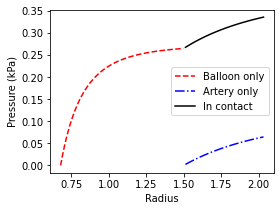

In [5]:
p_all = np.array(p_all)
p_art = np.array(p_art)
r_all = np.array(r_all)
contact = np.array(contact)
fig,ax = plt.subplots(1,1,figsize=(4,3))

ax.plot(r_all[~contact],p_all[~contact],'--r',label='Balloon only')
ax.plot(r_all[contact],p_art,'-.b',label='Artery only')
ax.plot(r_all[contact],p_all[contact],'-k',label='In contact')
ax.set_xlabel('Radius')
ax.set_ylabel('Pressure (kPa)')
plt.legend()
plt.show()